# 📝 Project Introduction
## Monkeypox Disease Detection with ResNet152

- In this project, we need to predict Monkeypox skin Disease from images of people with skin infection.

- We will use the ResNet152 model with a dataset of images with labeled skin disease images from Monkeypox and Healthy classes.

- Given that the model is powerful and well-suited for this task I have achieved 89% training accuracy with reliable results.

## Fetching the data
Fetching the data from kaggle(you can skip it if you already on kaggle)

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"beshoyhakeem","key":"a6a2a07c95e6f6673c6f1551739a7e66"}'}

In [2]:
!mkdir -p ~/.kaggle

In [3]:
!mv kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20

Dataset URL: https://www.kaggle.com/datasets/joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 95% 540M/567M [00:01<00:00, 325MB/s]
100% 567M/567M [00:01<00:00, 419MB/s]


In [ ]:
!unzip mpox-skin-lesion-dataset-version-20-msld-v20 -d dataset/

# Importing libraries we will use

In [17]:
import os, shutil, random
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Now, let's prepare our data

- We have two folders, Augmented Images and Original Images. I will use the Augmented to give the model more examples.

- But we have a small problem, that is the structure of the data inside the Augmented folder is like this:
```
dataset/  
└── Augmented Images/  
    └── Augmented Images/  
        └── FOLDS_AUG/  
            ├── fold1_AUG/  
            │   └── Train/  
            │       ├── Chickenpox/      
            │       ├── Cowpox/      
            │       ├── HFMD/  
            │       ├── Healthy/
            │       └── Measles/  
            │       └── Monkeypox/  
            │  
            ├── fold2_AUG/  
            │   └── Train/    
            │       ├── Chickenpox/        
            │       ├── Cowpox/      
            │       ├── HFMD/    
            │       ├── Healthy/   
            │       └── Measles/  
            │       └── Monkeypox/  
            │  
            ├── fold3_AUG/  
            ├── fold4_AUG/  
            └── fold5_AUG/  
```

- 5 folders have different Augmented images inside them. Each folder has a train folder that has 6 classes inside it.

- So what we need to do is to collect all the images from each folder into one folder with 6 classes

## That's what this code does: it collects all images into one folder with 6 class folders to be like this:

```
Unified_Train/
  ├── Chickenpox/
  ├── Cowpox/
  ├── HFMD/
  ├── Healthy/
  ├── Measles/
  └── Monkeypox/
```

In [8]:
# Define paths
data_root = Path('/content/dataset/Augmented Images/Augmented Images/FOLDS_AUG')
unified_train_dir = Path('/content/dataset/Unified_Train')

# Create a unified train directory
if not unified_train_dir.exists():
    os.makedirs(unified_train_dir)

# Track the total number of files copied
total_files_copied = 0

# Collect all 'Train' subfolders
for fold in data_root.iterdir():
    train_path = fold / 'Train'

    if train_path.exists() and train_path.is_dir():
        for category_folder in train_path.iterdir():
            if category_folder.is_dir():
                category_name = category_folder.name
                # Create category directory in unified_train_dir if not exists
                unified_category_dir = unified_train_dir / category_name
                if not unified_category_dir.exists():
                    os.makedirs(unified_category_dir)

                # Copy or link files from the category folder to unified directory
                for file in category_folder.glob('*'):
                    # Generate a unique name by appending the fold name to the original file name
                    new_file_name = f"{fold.name}_{file.name}"
                    destination = unified_category_dir / new_file_name

                    try:
                        shutil.copy(file, destination)
                        total_files_copied += 1
                    except Exception as e:
                        print(f"Error copying {file}: {e}")

print(f"Total files copied: {total_files_copied}")

Total files copied: 37044


## This function checks if each sample is unique, depending on the image name

In [9]:

def check_duplicate_filenames(root_dir):
    """Check for duplicate filenames across all categories"""
    filename_counter = defaultdict(list)  # filename -> list of paths where it appears

    # Walk through all directories
    for category in os.listdir(root_dir):
        category_path = os.path.join(root_dir, category)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                filename_counter[filename].append(category_path)

    # Find duplicates
    duplicates = {filename: paths for filename, paths in filename_counter.items()
                  if len(paths) > 1}

    return duplicates

# Usage
unified_train_dir = '/content/dataset/Unified_Train'
duplicates = check_duplicate_filenames(unified_train_dir)

if duplicates:
    print(f"Found {len(duplicates)} duplicate filenames:")
    for filename, paths in list(duplicates.items())[:10]:  # Show first 10
        print(f"  '{filename}' appears in: {', '.join(paths)}")
else:
    print("All filenames are unique across categories!")

All filenames are unique across categories!


## Function Counts number of samples in each class folder

In [10]:
def count_samples_per_folder(root_dir):
    """Count samples in each folder"""
    counts = {}

    # List all items in the root directory
    for item in os.listdir(root_dir):
        item_path = os.path.join(root_dir, item)

        # Check if it's a directory
        if os.path.isdir(item_path):
            # Count files in this directory
            files = [f for f in os.listdir(item_path)
                    if os.path.isfile(os.path.join(item_path, f))]
            counts[item] = len(files)

    return counts

# Usage
unified_train_dir = '/content/dataset/Unified_Train'
folder_counts = count_samples_per_folder(unified_train_dir)

# Print results
print("📁 Samples per folder:")
print("=" * 30)
total_samples = 0
for folder, count in sorted(folder_counts.items()):
    print(f"{folder}: {count} samples")
    total_samples += count

print("=" * 30)
print(f"Total folders: {len(folder_counts)}")
print(f"Total samples: {total_samples}")

📁 Samples per folder:
Chickenpox: 3598 samples
Cowpox: 3220 samples
HFMD: 7882 samples
Healthy: 5656 samples
Measles: 2618 samples
Monkeypox: 14070 samples
Total folders: 6
Total samples: 37044


## To prevent any Class imbalance, I will use only Monkeypox and Healthy classes

In [11]:
# Setup
src = Path('/content/dataset/Unified_Train')
dst = Path('/content/dataset/mpox_Healthy_only')
dst.mkdir(parents=True, exist_ok=True)

# Copy 5656 from each class
for cls in ['Monkeypox', 'Healthy']:
    # Get all images
    imgs = list((src/cls).glob('*.*'))
    imgs = [f for f in imgs if f.suffix in ['.jpg','.jpeg','.png']]

    # Select 5656 randomly
    selected = random.sample(imgs, min(5656, len(imgs)))

    # Create folder and copy
    (dst/cls).mkdir(parents=True, exist_ok=True)
    for img in selected:
        shutil.copy(img, dst/cls/img.name)

    print(f"{cls}: {len(selected)} images copied")

Monkeypox: 5656 images copied
Healthy: 5656 images copied


## Load the data, split to train and val, and resize them

In [73]:
# Define image parameters
img_height = 224
img_width = 224
batch_size = 32

Mpox_only = '/content/dataset/mpox_Healthy_only'

# Use the unified train directory for dataset creation
train_ds = tf.keras.utils.image_dataset_from_directory(
    Mpox_only,
    validation_split=0.15,
    subset="training",
    seed=321,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    Mpox_only,
    validation_split=0.15,
    subset="validation",
    seed=321,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Print class names to verify
class_names = train_ds.class_names
print(class_names)

Found 11312 files belonging to 2 classes.
Using 9616 files for training.
Found 11312 files belonging to 2 classes.
Using 1696 files for validation.
['Healthy', 'Monkeypox']


## Here's what samples from the train look like

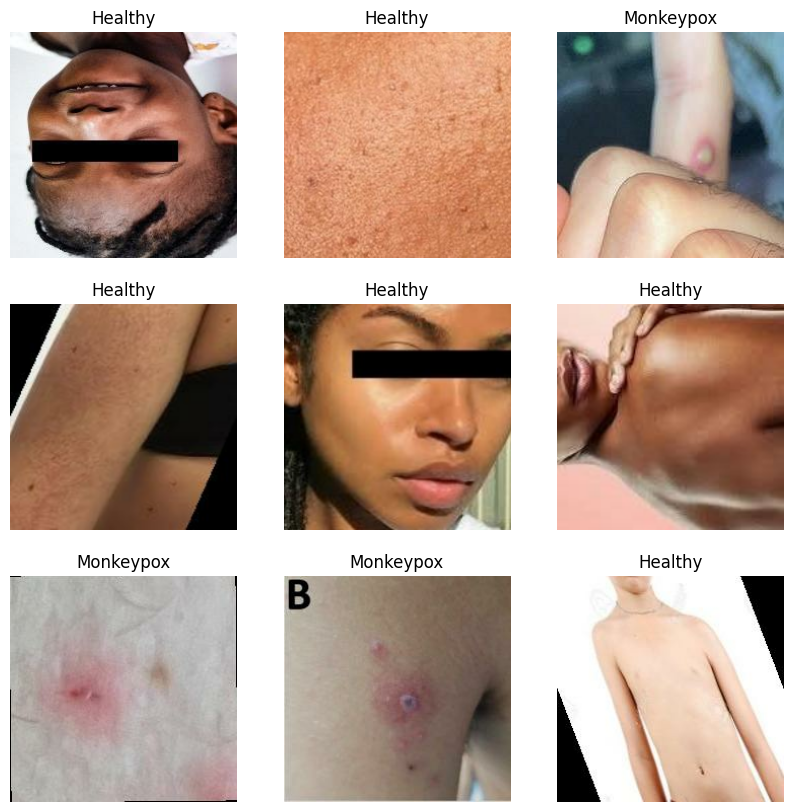

In [23]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

##Setup up ResNet-152 model and train the model

- Normlized the data between 0 - 1 to prevent Exploding gradients.

- Used the ResNet-152 model trained on 'imagenet' data that has human images.

- Removed the classification layer and added a 2 Dense layer neurons with ReLU activation to train them on my task.

- Added a sigmoid layer for binary classification.

- Used Adam optimizer and binary_crossentropy.

- Put CallBacks, EarlyStopping if the validation loss stops improving, And ReduceLR if the vavalidation didnt improve for 2 epochs.

In [ ]:
# Extract class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)
print(f'Class names: {class_names}')
print(f'Number of classes: {num_classes}')

# Normalize the data
normalization_layer = tf.keras.layers.Rescaling(1./255)

def preprocess_dataset(dataset):
    dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
    return dataset

train_ds = preprocess_dataset(train_ds)
val_ds = preprocess_dataset(val_ds)

# ResNet-152 model setup
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)         
x = BatchNormalization()(x)  
x = tf.keras.layers.ReLU()(x)
x = Dropout(0.5)(x)        
x = Dense(256)(x)          
x = BatchNormalization()(x)  
x = tf.keras.layers.ReLU()(x)
x = Dropout(0.3)(x)       
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Set the initial learning rate and compile the model
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Create callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

Class names: ['Healthy', 'Monkeypox']
Number of classes: 2
Epoch 1/15
301/301 ━━━━━━━━━━━━━━━━━━━━ 133s 321ms/step - accuracy: 0.6826 - loss: 0.6228 - val_accuracy: 0.5053 - val_loss: 0.9118 - learning_rate: 0.0010
Epoch 2/15
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 249ms/step - accuracy: 0.7599 - loss: 0.5022 - val_accuracy: 0.6008 - val_loss: 1.1153 - learning_rate: 0.0010
Epoch 3/15
301/301 ━━━━━━━━━━━━━━━━━━━━ 77s 255ms/step - accuracy: 0.7794 - loss: 0.4559 - val_accuracy: 0.7535 - val_loss: 0.4835 - learning_rate: 0.0010
Epoch 4/15
301/301 ━━━━━━━━━━━━━━━━━━━━ 77s 255ms/step - accuracy: 0.7943 - loss: 0.4417 - val_accuracy: 0.5425 - val_loss: 1.2075 - learning_rate: 0.0010
Epoch 5/15
301/301 ━━━━━━━━━━━━━━━━━━━━ 77s 256ms/step - accuracy: 0.8046 - loss: 0.4137 - val_accuracy: 0.7123 - val_loss: 0.5209 - learning_rate: 0.0010
Epoch 6/15
301/301 ━━━━━━━━━━━━━━━━━━━━ 77s 257ms/step - accuracy: 0.8402 - loss: 0.3683 - val_accuracy: 0.8555 - val_loss: 0.3349 - learning_rate: 2.0000e-04
Epoch 

Making predictions...


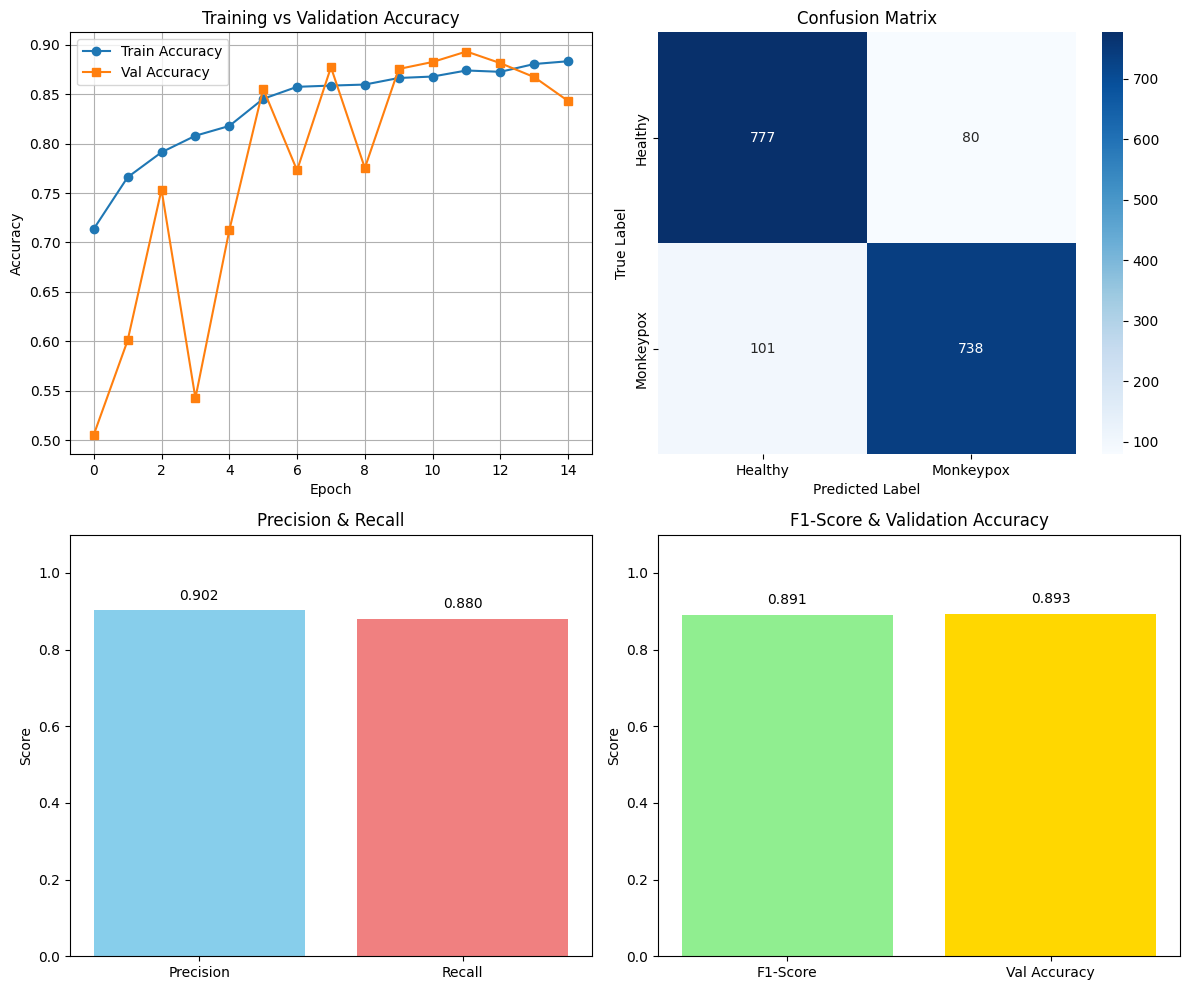


MODEL PERFORMANCE METRICS

📊 Confusion Matrix (array format):
[[777  80]
 [101 738]]

Rows: True labels (Healthy, Monkeypox)
Cols: Predicted labels (Healthy, Monkeypox)
Validation Accuracy: 89.33%
Precision: 0.9022
Recall: 0.8796
F1-Score: 0.8908

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.88      0.91      0.90       857
   Monkeypox       0.90      0.88      0.89       839

    accuracy                           0.89      1696
   macro avg       0.89      0.89      0.89      1696
weighted avg       0.89      0.89      0.89      1696



In [75]:
# 1. Plot: Training vs Validation Accuracy
plt.figure(figsize=(12, 10))

# Plot 1: Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 2. Get predictions for confusion matrix and metrics
print("Making predictions...")
y_true = []
y_pred = []
y_pred_proba = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())
    y_pred_proba.extend(preds.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 3. Plot: Confusion Matrix
plt.subplot(2, 2, 2)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 4. Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
val_accuracy = np.mean(y_true == y_pred)

# 5. Plot: Precision & Recall
plt.subplot(2, 2, 3)
metrics = ['Precision', 'Recall']
values = [precision, recall]
colors = ['skyblue', 'lightcoral']
bars = plt.bar(metrics, values, color=colors)
plt.ylim(0, 1.1)
plt.title('Precision & Recall')
plt.ylabel('Score')

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{value:.3f}', ha='center', va='bottom')

# 6. Plot: F1-Score & Accuracy
plt.subplot(2, 2, 4)
metrics2 = ['F1-Score', 'Val Accuracy']
values2 = [f1, val_accuracy]
colors2 = ['lightgreen', 'gold']
bars2 = plt.bar(metrics2, values2, color=colors2)
plt.ylim(0, 1.1)
plt.title('F1-Score & Validation Accuracy')
plt.ylabel('Score')

# Add value labels on bars
for bar, value in zip(bars2, values2):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 7. Print metrics
print("\n" + "="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)

# Print confusion matrix
print("\n📊 Confusion Matrix (array format):")
print(cm)
print(f"\nRows: True labels ({class_names[0]}, {class_names[1]})")
print(f"Cols: Predicted labels ({class_names[0]}, {class_names[1]})")


print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

## Save the model into Keras format

In [76]:
model.save('/content/mpox4.keras')
print("Model saved in Keras format.")

Model saved in Keras format.


## Function to predict images

In [77]:
#Load the model
model = tf.keras.models.load_model("/content/mpox4.keras")

def predict_single_image(image_path, img_height=224, img_width=224):
    """
    Predict a single image
    Returns: class prediction and confidence
    """
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(
        image_path,
        target_size=(img_height, img_width)
    )

    # Convert to array and preprocess
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize (same as training)

    # Make prediction
    prediction = model.predict(img_array, verbose=0)

    # Since you're using sigmoid with 1 output neuron:
    # Values close to 0 = Class 0, Values close to 1 = Class 1
    confidence = prediction[0][0]

    # Determine class based on threshold (0.5)

    if confidence > 0.5:
      predicted_class = "Monkeypox"
      probability = confidence*100

    else:
      predicted_class = "Healthy Skin Or Not Monkeypox"
      probability = (1 - confidence)*100

    return predicted_class, probability

## Predicting samples

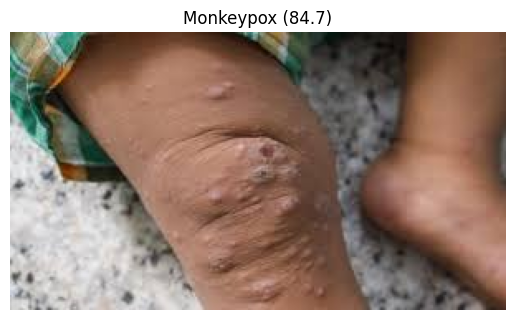

Predicted: Monkeypox (Confidence: 84.7)


In [98]:
# Example usage
image_path = "/content/mpox.jpg"
pred_class, confidence = predict_single_image(image_path)
plt.imshow(Image.open(image_path)); plt.title(f"{pred_class} ({confidence:.1f})"); plt.axis('off'); plt.show()
print(f"Predicted: {pred_class} (Confidence: {confidence:.1f})")

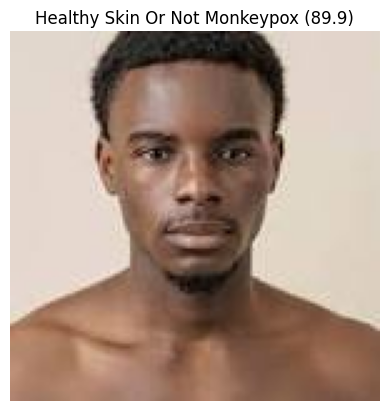

Predicted: Healthy Skin Or Not Monkeypox (Confidence: 89.9)


In [100]:
# Example usage
image_path = "/content/Healthy2.jpg"
pred_class, confidence = predict_single_image(image_path)
plt.imshow(Image.open(image_path)); plt.title(f"{pred_class} ({confidence:.1f})"); plt.axis('off'); plt.show()
print(f"Predicted: {pred_class} (Confidence: {confidence:.1f})")